In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pydantic import BaseModel, Field

import nest_asyncio
nest_asyncio.apply()
from llama_index.core.vector_stores.types import MetadataFilters, MetadataFilter, FilterOperator, FilterCondition
from llama_index.core.prompts import PromptTemplate
from llama_index.core.output_parsers.pydantic import PydanticOutputParser
from llama_index.core.schema import TextNode, IndexNode, NodeRelationship, RelatedNodeInfo
from typing import List, Dict
import re
import plotreader
from plotreader.utils.document import ScientificPaperHandler

In [100]:
handler = ScientificPaperHandler(
    filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/nihms-1538039.pdf",
    document_id = "3de6841c-fba6-4124-a28a-2c53124202af",
    # filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/s42003-021-01878-9.pdf",
    # document_id = "b562c2f2-b776-4829-b18c-6c6ebf4f788d",
    name="nihms-1538039",
    desc="A scientific paper",
    storage_dir = "./storage",
    use_cache = False
)

In [101]:
all_nodes = handler.load_docs()

In [128]:
all_nodes

[TextNode(id_='2489352a-7c62-4272-8a19-0746ceb0f845', embedding=None, metadata={'Header_1': 'Machine learning-guided channelrhodopsin engineering enables minimally-invasive optogenetics', 'experimental_variable_entities': ['channelrhodopsin', 'optogenetics'], 'fig_refs': []}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='ad124c4a-c5a1-4e15-aa56-bb1ec1f6db0c', node_type=None, metadata={}, hash=None)}, text='Machine learning-guided channelrhodopsin engineering enables minimally-invasive optogenetics\n\nClaire N. Bedbrook<sup>1</sup>, Kevin K. Yang<sup>2,†</sup>, J. Elliott Robinson<sup>1,†</sup>, Elisha D. Mackey<sup>1</sup>, Viviana Gradinaru<sup>1,*</sup>, Frances H. Arnold<sup>1,2,*<

In [135]:
fig_num = 3

filters = MetadataFilters(filters=[
    MetadataFilter(
        key="fig_refs", 
        value='Figure {fig_num}',
        operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2d',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2e',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    )],
    condition=FilterCondition.OR
)

query_tool = handler.query_engine_tool(top_k=10, metadata_filters=filters)

In [136]:
class Variable(BaseModel):
    name: str
    categorical: bool

class Experiment(BaseModel):
    independent_variables: list[Variable]
    dependent_variables: list[Variable]

class Plot(BaseModel):
    name: str
    experiments: list[Experiment]

class Panel(BaseModel):
    name: str
    plots: list[Plot]

class Figure(BaseModel):
    name: str
    panels: list[Panel]
    # statistics: List[str]



In [138]:
output_parser = PydanticOutputParser(output_cls=Figure)

prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting data from figures in scientific papers.
    You will always primarily look to the image of the figure.
    You will look to text to obtain more detail if necessary.
    When there is a discrepency between text and graphic, always defer to the graphic.

YOUR CURRENT TASK:
Complete the following task by visual inspection of the figure ONLY. Omit information if not available in the image.
For each plot in each panel of THE IMAGE of Fig. {fig_num}, determine the experiment in terms of Independent variables (IVs) and dependent variable (DV). 
By plot, we mean each set of axes or displays. Each panel can have multiple plots. See the json definition below for more.

Return your answer as structured data.
"""

prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

In [139]:
response = query_tool(prompt)

In [140]:
figure_struct = output_parser.parse(response.content)

In [141]:
fig_description = f"{figure_struct.name}"

for panel in figure_struct.panels:
    fig_description += f"\n\tPanel: {panel.name}\n"
    for plot in panel.plots:
        fig_description += f"\n\t\tPlot: {plot.name}"
        for experiment in plot.experiments:
            fig_description += f"\n\t\t\t{experiment}"

print(fig_description)

Figure 3
	Panel: b

		Plot: Microscope images
			independent_variables=[Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Neuron morphology', categorical=False)]
	Panel: c

		Plot: Photocurrent bar graphs
			independent_variables=[Variable(name='ChR variant', categorical=True), Variable(name='Light intensity', categorical=True)] dependent_variables=[Variable(name='Photocurrent', categorical=False)]
	Panel: d

		Plot: Spike fidelity vs Light intensity
			independent_variables=[Variable(name='Light intensity', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Spike fidelity', categorical=False)]
	Panel: e

		Plot: Spike fidelity vs Frequency
			independent_variables=[Variable(name='Frequency', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Spike fidelity', categorical=False)]
	Panel: f

		Plot: Voltage traces
			independent_variables=[Variable(n

In [ ]:
filters = MetadataFilters(filters=[
    MetadataFilter(
        key="fig_refs", 
        value='Figure 3',
        operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2d',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2e',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    )],
    condition=FilterCondition.OR
)

query_tool = handler.query_engine_tool(top_k=10, metadata_filters=filters)

In [150]:
panel = figure_struct.panels[2]
plot = panel.plots[0]
exp = plot.experiments[0]

class CategoricalVariable(BaseModel):
    name: str
    label_type: str = Field(
        ...,
        description="What type of visual signifier is used to label this class in the plot (e.g. color, markertype, etc.)"
    )
    values: dict[str, str] = Field(
        ...,
        description="A map from Category > Label that can act as a legend for this variable."
    )

class NumericVariable(BaseModel):
    name: str
    values: list[float]
    unit: str

plot_struct_str = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_struct_str += f"\n\t{experiment}"

ivs_with_values = []

for iv in exp.independent_variables:

    print(iv)
    if iv.categorical:

        var_cls = CategoricalVariable
        prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting categorical labels from plots in scientific papers.
    You will always primarily look to the image of the figure.
    If the information is not available in the image, you can look to the text.
    You will always dummy check your answer by counting the number of expected labels in the image.
    When there is a discrepency between text and graphic, always defer to the graphic.

YOUR CURRENT TASK:
        In Figure {fig_num}{panel.name}, plot title: {plot.name}, what values are taken by the independent variable {iv.name}?
    Return your answer as structured data.
        """
        
    else:
        var_cls = NumericVariable
        prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting the values of data points from plots in scientific papers.
    You will be given an numeric independent variable and a plot containing datapoints corresponding to that variable.
    Your job is to give the set of values for that variable for the markers in the the specific plot (not the whole figure). 
    You will always dummy check your answer by counting the number of expected datapoints in the plot.

    YOUR CURRENT TASK:

In Figure {fig_num}{panel.name}, plot title/description: {plot.name}, what set are the values of {iv.name} plotted across all data in the panel?
    IMPORTANT: 
        WE WANT TO MATCH THE FIGURE. USE THE TEXT TO HELP, BUT IF THERE IS A DISCREPANCY, RESOLVE ASSUMING THE IMAGE IS CORRECT.
        COUNT THE NUMBER OF POINTS OR LINES IN THE IMAGE TO ENSURE THAT YOU RETURN THE CORRECT NUMBER OF VALUES.
        THAT IS, DO NOT REPORT THE LOCATIONS OF AXIS TICKE MARKS OR TICK MARK LABELS, REPORT THE VALUES OF THE POINTS ON THE PLOT!!!
    Return your answer as structured data.
        """

    # prompt = f"""In Figure 2, what categories are shown for the independent variable: {exp.independent_variables[1].name}?

    # What categories are shown in this plot for the independent variable: {exp.independent_variables[1].name}?

    # {our_info}
    # """

    output_parser = PydanticOutputParser(output_cls=var_cls)
    prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    # response = query_tool(prompt)
    # text = response.content

    response = query_tool(prompt)
    text = response.content

    ivs_with_values.append(output_parser.parse(text))
# print(var_struct)


name='Light intensity' categorical=False
name='ChR variant' categorical=True


In [151]:
ivs_with_values

[NumericVariable(name='Light intensity', values=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0], unit='mW mm^-2'),
 CategoricalVariable(name='ChR variant', label_type='color', values={'ChRger1': 'pink', 'ChRger2': 'blue', 'ChRger3': 'green', 'CoChR': 'gray', 'ChR2': 'black'})]

In [152]:
response.raw_output.source_nodes

[NodeWithScore(node=TextNode(id_='7ff45e61-0239-4cd0-9902-00f4f80a99df', embedding=None, metadata={'Header_1': 'Online methods', 'Header_2': 'References', 'Header_3': 'Figure 3. ChRger variants in cultured neurons and in acute brain slices outperform the commonly used ChR2(H134R) and the high performance CoChR. (continued)', 'experimental_variable_entities': ['ChRger variants', 'ChR2(H134R)', 'CoChR', 'light irradiances', 'rAAV-PHP.eB', 'hSyn-ChRger2', 'hSyn-ChR2(H134R)', 'fraction of light excitable neurons', 'photocurrent strength', 'spike fidelity', 'stimulation frequency', 'viral genomes'], 'fig_refs': ['Figure 3']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='eb17ddf0-0275-4cb0

In [153]:
from plotreader.utils.structured_types.data import DataFrameRowsOnly
import pandas as pd

In [353]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You are an expert at extracting the values of data points from plots in scientific papers.
    You will be given an numeric dedependent variable and a plot containing datapoints showing data with that variable.
    Your job is to give values for the markers in the plot as a function of the provided independent variables.
    You will always dummy check your answer by counting the number of expected datapoints, lines, etc in the plot.
    When there is a discrepency between text and graphic, align your answer to the graphic.

In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?
Get the value for each condition. To help, here is our current belief on the independent variables and their values for this plot:
{ind_vars}

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response = query_tool(prompt)
panel_df = output_parser.parse(data_response.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


In [354]:
data_response.raw_output.source_nodes

[NodeWithScore(node=TextNode(id_='7ff45e61-0239-4cd0-9902-00f4f80a99df', embedding=None, metadata={'Header_1': 'Online methods', 'Header_2': 'References', 'Header_3': 'Figure 3. ChRger variants in cultured neurons and in acute brain slices outperform the commonly used ChR2(H134R) and the high performance CoChR. (continued)', 'experimental_variable_entities': ['ChRger variants', 'ChR2(H134R)', 'CoChR', 'light irradiances', 'rAAV-PHP.eB', 'hSyn-ChRger2', 'hSyn-ChR2(H134R)', 'fraction of light excitable neurons', 'photocurrent strength', 'spike fidelity', 'stimulation frequency', 'viral genomes'], 'fig_refs': ['Figure 3']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='eb17ddf0-0275-4cb0

In [355]:
chr_variant_iv = [iv for iv in ivs_with_values if iv.name == 'ChR variant'][0]
# chr_variant_names = [v for v in chr_variant_iv.values]
chr_variant_colors = [v for k,v in chr_variant_iv.values.items()]

# def get_color(color_name):
#     try:
#         return mcolors.to_rgba(color_name)
#     except ValueError:
#         # If the color name is not recognized, you can provide a fallback
#         return mcolors.to_rgba('gray')
    



In [356]:
import seaborn as sns

[]

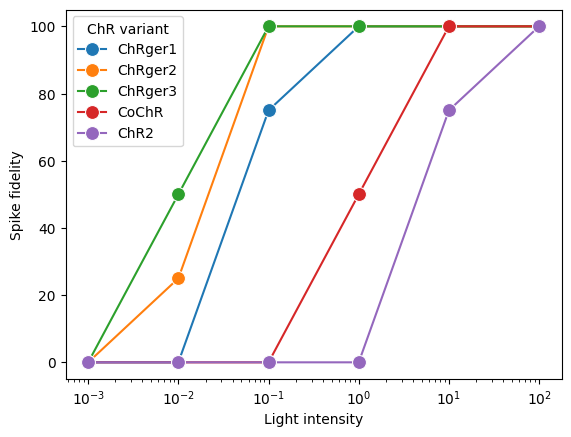

In [363]:


axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [327]:
from PIL import Image

# get plot as PIL Image
fig = axes.get_figure()
fig.savefig('plot.png')
generated_img = Image.open('plot.png')

In [328]:
from llama_index.core.schema import ImageNode
import requests
from io import BytesIO

from plotreader.utils.base import BasicAnthropicLLM

claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620")

for node in data_response.raw_output.source_nodes:
    if isinstance(node.node, ImageNode):
        response = requests.get(node.node.image_url)
        source_figure = Image.open(BytesIO(response.content))

prompt = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
List the three most important differences between the re-plotted data and the data in the source figure.
Be specific and refer to specific quantities and values.

DataFrame:
{panel_df.to_markdown()}
"""


response = claude_mm.message(prompt, images = [source_figure, generated_img])

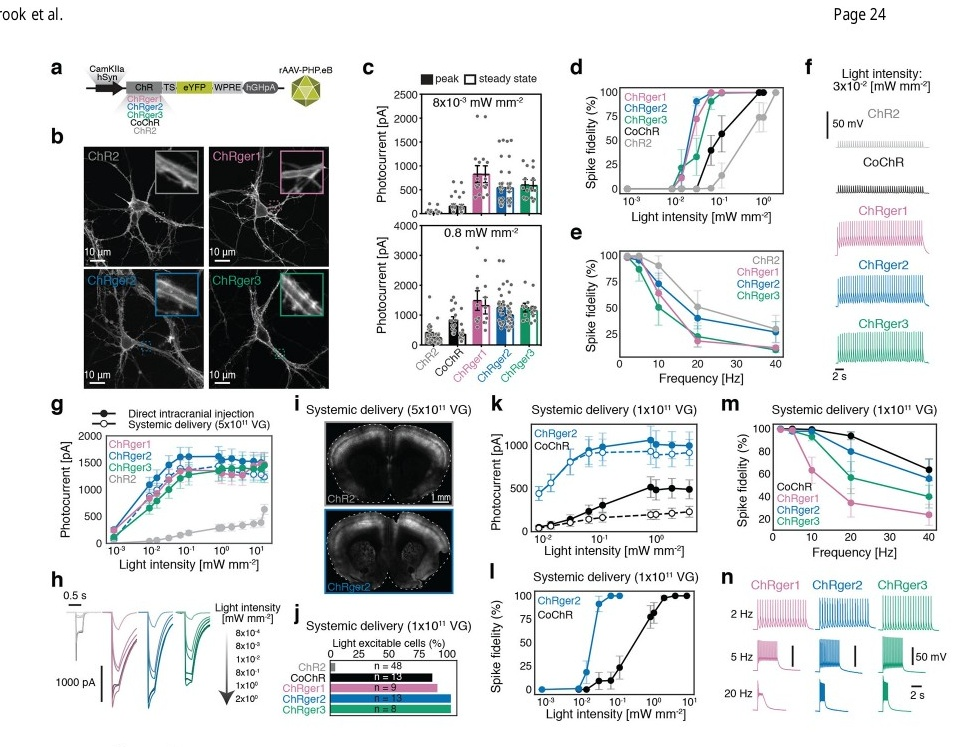

In [329]:
source_figure

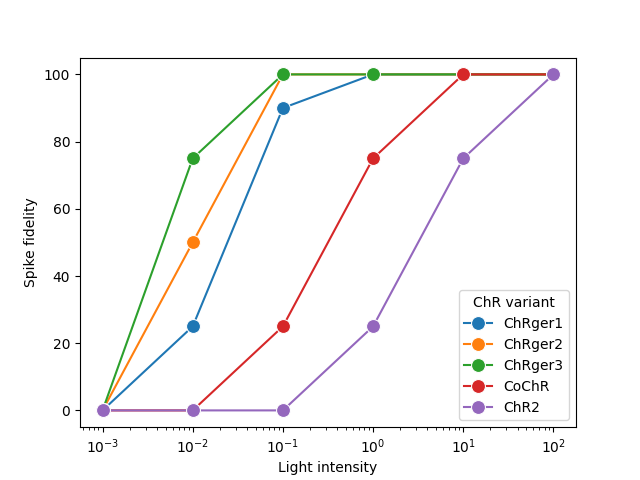

In [330]:
generated_img

In [331]:
print(response.content[0].text)

After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Curve shape for ChRger1, ChRger2, and ChRger3: In the source figure, these curves appear to be smoother and more sigmoidal, especially between 0.01 and 0.1 mW/mm². In the re-plotted data, these curves are more angular and abrupt. For example, ChRger3 in the re-plot jumps from 75% to 100% spike fidelity between 0.01 and 0.1 mW/mm², while in the original, it appears to have a more gradual increase.

2. CoChR performance at low light intensities: In the source figure, CoChR shows some activity (around 25% spike fidelity) at 0.01 mW/mm². However, in the re-plotted data, CoChR shows 0% spike fidelity at 0.01 mW/mm² and only starts showing activity (25%) at 0.1 mW/mm².

3. ChR2 performance at higher light intensities: In the source figure, ChR2 appears to reach close to 100% spike fidelity at 100 mW/mm². In the re-plotted data, ChR2 reaches exactly 100% at this intensity

In [332]:
feedback = response.content[0].text

In [351]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You were previously given the following task:

        In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?

    Here is your previous response:
    {df_table}

    We have reviewed your response and notice these important differences from the source figure:
    {feedback}

    Please revise your response by incorporating and inspecting the source figure.

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
    feedback = feedback,
    df_table = panel_df.to_markdown(),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response_revised = query_tool(prompt)
panel_df = output_parser.parse(data_response_revised.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


[]

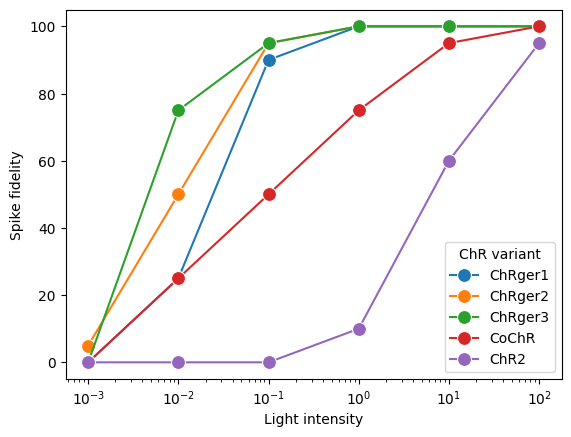

In [352]:


axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [345]:
# get plot as PIL Image
fig = axes.get_figure()
fig.savefig('plot.png')
generated_img_rev = Image.open('plot.png')

In [346]:


claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620")


prompt = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
List the three most important differences between the re-plotted data and the data in the source figure.
Be specific and refer to specific quantities and values.

DataFrame:
{panel_df.to_markdown()}
"""


response_2 = claude_mm.message(prompt, images = [source_figure, generated_img_rev])

In [347]:
feedback_2 = response_2.content[0].text
print(feedback_2)

After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Curve shape for ChRger1: In the source figure, the ChRger1 curve (pink) shows a more gradual increase in spike fidelity between 0.01 and 0.1 mW/mm². However, in the re-plotted data, there's a sharp jump from 25% at 0.01 mW/mm² to 95% at 0.1 mW/mm². This difference significantly alters the shape of the curve for ChRger1 in the low light intensity range.

2. CoChR performance at low intensities: In the source figure, the CoChR curve (black) shows some activity (around 20-30% spike fidelity) at 0.01 mW/mm². However, in the re-plotted data, CoChR shows 0% spike fidelity at 0.01 mW/mm². This difference affects the interpretation of CoChR's sensitivity at low light intensities.

3. ChR2 curve shift: In the source figure, the ChR2 curve (gray) begins to rise noticeably around 1 mW/mm² and reaches about 50% spike fidelity at 10 mW/mm². In the re-plotted data, the ChR2 curv

In [364]:
panel_df

,Light intensity,ChR variant,Spike fidelity
0,0.001,ChRger1,0
1,0.010,ChRger1,0
2,0.100,ChRger1,75
3,1.000,ChRger1,100
4,10.000,ChRger1,100
5,100.000,ChRger1,100
6,0.001,ChRger2,0
7,0.010,ChRger2,25
8,0.100,ChRger2,100
9,1.000,ChRger2,100


In [348]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You were previously given the following task:

        In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?

    Here is your previous response:
    {df_table}

    We have reviewed your response and notice these important differences from the source figure:
    {feedback}

    Please revise your response by incorporating and inspecting the source figure.

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
    feedback = feedback_2,
    df_table = panel_df.to_markdown(),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response_revised = query_tool(prompt)
panel_df = output_parser.parse(data_response_revised.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


[]

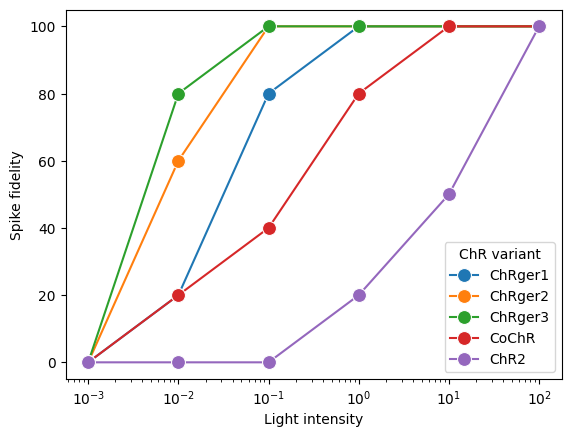

In [349]:


axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Curve shape for ChR2: In the source figure, the ChR2 curve (gray) shows a gradual increase in spike fidelity from about 10^0 to 10^2 mW mm^-2. However, in the re-plotted data, the ChR2 curve shows a sharp jump from 0% to 75% spike fidelity between 1 and 10 mW mm^-2, and then to 100% at 100 mW mm^-2. This difference in curve shape is significant and doesn't capture the gradual increase seen in the original figure.

2. CoChR sensitivity: In the source figure, the CoChR variant (black) shows some activity (non-zero spike fidelity) at light intensities as low as 10^-1 mW mm^-2. In contrast, the re-plotted data shows CoChR having 0% spike fidelity at 0.1 mW mm^-2, only starting to show activity (50% spike fidelity) at 1 mW mm^-2. This suggests a lower sensitivity in the re-plotted data compared to the original figure.

3. ChRger variants' relative performance: In the so

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Curve shape for ChR2: In the source figure, the ChR2 curve (gray) shows a more gradual increase in spike fidelity from 1 to 100 mW mm^-2. However, in the re-plotted data, the ChR2 curve shows a steeper increase, jumping from 5% at 1 mW mm^-2 to 50% at 10 mW mm^-2, and then to 95% at 100 mW mm^-2. This makes the re-plotted curve appear more step-like compared to the smoother curve in the original figure.

2. CoChR performance at low intensities: In the source figure, the CoChR curve (black) shows some activity (around 10-20% spike fidelity) at 0.01 mW mm^-2. However, in the re-plotted data, CoChR shows 0% spike fidelity at 0.01 mW mm^-2, only starting to show activity (10% spike fidelity) at 0.1 mW mm^-2.

3. ChRger3 saturation point: In the source figure, ChRger3 (green) reaches 100% spike fidelity at around 0.05-0.07 mW mm^-2. In the re-plotted data, ChRger3 only 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Curve shape for ChR2: In the source figure, the ChR2 curve shows a more gradual increase in spike fidelity, starting from around 10^-1 mW mm^-2. However, in the re-plotted data, the ChR2 curve remains at 0% spike fidelity until 1 mW mm^-2, then jumps to 10%. This difference is particularly noticeable in the 10^-1 to 1 mW mm^-2 range.

2. Maximum spike fidelity for ChR2: In the source figure, ChR2 appears to reach close to 100% spike fidelity at the highest light intensity (10^2 mW mm^-2). However, in the re-plotted data, ChR2 only reaches 80% spike fidelity at this intensity.

3. Curve shape for CoChR: The re-plotted data shows a more step-like increase for CoChR, with distinct jumps at each light intensity level. In contrast, the source figure displays a smoother, more continuous curve for CoChR, especially in the range from 10^-2 to 1 mW mm^-2. For example, at 0.

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Curve shape for ChR2: In the source figure, the ChR2 curve (gray) has a more gradual, sigmoidal shape. In the re-plotted data, the ChR2 curve (purple) appears more step-like, with a sharp increase between 1 and 10 mW/mm². The original figure shows a more gradual increase starting from around 0.1 mW/mm².

2. CoChR performance at low intensities: In the source figure, the CoChR curve (red) shows higher spike fidelity at low light intensities compared to the re-plotted data. For example, at 0.01 mW/mm², the original figure shows a spike fidelity of about 30-40%, while the re-plotted data shows only 15%.

3. Relative positioning of ChRger variants: In the source figure, the curves for ChRger1, ChRger2, and ChRger3 are more tightly grouped and cross each other multiple times. In the re-plotted data, these curves are more distinctly separated, particularly at 0.01 mW/mm²

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Curve shape for ChR2: In the source figure, the ChR2 curve has a more gradual, sigmoidal shape. However, in the re-plotted data, the ChR2 curve appears more linear between light intensities of 0.1 and 10 mW/mm². The re-plotted data shows a sharp increase from 10% to 80% spike fidelity between 0.1 and 10 mW/mm², while the original figure shows a more gradual increase.

2. Maximum spike fidelity for CoChR: In the source figure, CoChR reaches 100% spike fidelity at around 10 mW/mm². However, in the re-plotted data, CoChR only reaches 98% spike fidelity at 1 mW/mm² and then jumps to 100% at 10 mW/mm². This creates a small plateau in the re-plotted data that is not present in the original figure.

3. Relative positions of ChRger variants: In the source figure, the curves for ChRger1, ChRger2, and ChRger3 are more tightly clustered and cross each other multiple times. In

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Curve shape for ChR2: In the source figure, the ChR2 curve (gray) shows a more gradual increase in spike fidelity, starting to rise around 10^-1 mW mm^-2. However, in the re-plotted data, the ChR2 curve remains at 0% until 1 mW mm^-2, then jumps to 20%. This difference is particularly noticeable in the 0.1-1 mW mm^-2 range.

2. Maximum spike fidelity for ChR2: In the source figure, ChR2 appears to reach close to 100% spike fidelity at the highest light intensity (10^2 mW mm^-2). However, in the re-plotted data, ChR2 only reaches 95% at this intensity, showing a discrepancy in the maximum achievable spike fidelity for this variant.

3. CoChR performance at low intensities: In the source figure, the CoChR curve (black) shows some activity at lower light intensities, around 10^-2 mW mm^-2. In contrast, the re-plotted data shows 0% spike fidelity for CoChR at 0.01 mW m

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Data point density: The source figure appears to have more data points, especially in the transition regions between low and high spike fidelity. For example, the CoChR curve in the original figure shows a more gradual increase from 0.01 to 1 mW/mm², while the re-plotted data only has three points in this range (at 0.01, 0.1, and 1 mW/mm²).

2. ChR2 curve shape: In the re-plotted data, the ChR2 curve shows a sharp increase from 30% to 80% spike fidelity between 1 and 10 mW/mm². In contrast, the original figure shows a more gradual increase in this range, with the curve appearing smoother and less steep.

3. Precision of maximum spike fidelity: The re-plotted data shows all variants reaching exactly 100% spike fidelity at their peak, while the original figure suggests slight variations. For instance, CoChR appears to plateau slightly below 100% in the original, wher

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, here are the three most important differences:

1. Data point density: The re-plotted graph has more data points for each ChR variant, especially in the lower light intensity range. For example, the ChRger variants (ChRger1, ChRger2, ChRger3) in the re-plotted graph have data points at 0.001, 0.003, and 0.01 mW/mm², while the source figure appears to have fewer points in this range.

2. ChR2 curve shape: In the re-plotted graph, the ChR2 curve (purple) shows a more gradual increase in spike fidelity, starting to rise around 0.1 mW/mm². In contrast, the source figure shows the ChR2 curve remaining close to 0% spike fidelity until about 1 mW/mm², then rising more steeply.

3. CoChR performance at low intensities: The re-plotted graph shows CoChR (red) reaching about 20% spike fidelity at 0.03 mW/mm², while in the source figure, CoChR appears to have lower performance at this light intensity, only reaching about 5-10% spike fidel

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Data point density: The re-plotted graph has fewer data points for each ChR variant compared to the original figure. This is particularly noticeable for CoChR and ChR2, where the original figure shows more intermediate points, especially in the rising phase of the curves. For example, the original CoChR curve has about 7-8 visible points, while the re-plotted data only has 9 points total.

2. ChR2 curve shape: In the original figure, the ChR2 curve (gray) shows a more gradual increase starting from around 0.1 mW mm^-2, whereas in the re-plotted data, the ChR2 curve remains at 0% spike fidelity until 1 mW mm^-2, then rises more abruptly. This results in a different shape for the ChR2 curve, particularly in the 0.1-1 mW mm^-2 range.

3. Precise values for high spike fidelity: In the original figure, it's difficult to distinguish the exact values for high spike fideli

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Data point density: The re-plotted graph has more data points for each ChR variant compared to the original figure. For example, the ChR2 curve in the re-plotted graph has 9 data points, while the original figure appears to have only 5-6 visible points. This results in smoother, more detailed curves in the re-plotted version.

2. CoChR curve shape: In the original figure, the CoChR curve (red) appears to reach 100% spike fidelity at a light intensity of about 3-5 mW/mm². However, in the re-plotted graph, the CoChR curve reaches 100% at a higher light intensity of 10 mW/mm². This shifts the upper part of the CoChR curve slightly to the right in the re-plotted version.

3. ChRger1 low-intensity behavior: In the original figure, the ChRger1 curve (pink) appears to start rising from 0% spike fidelity at a light intensity slightly below 0.01 mW/mm². In contrast, the re-

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


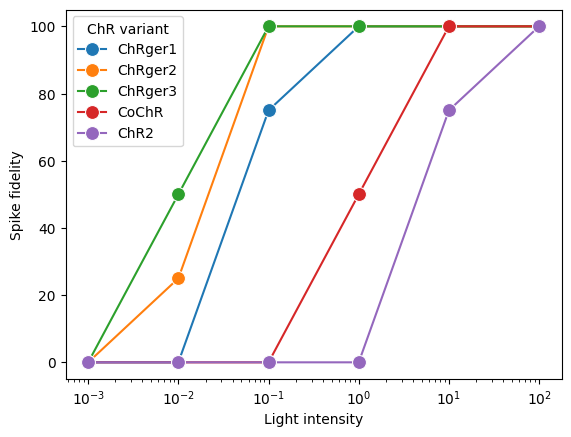

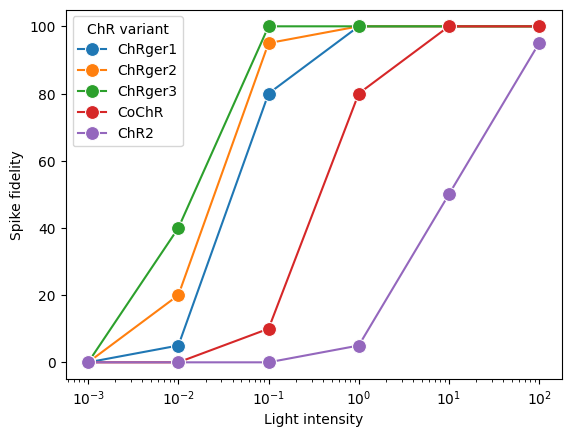

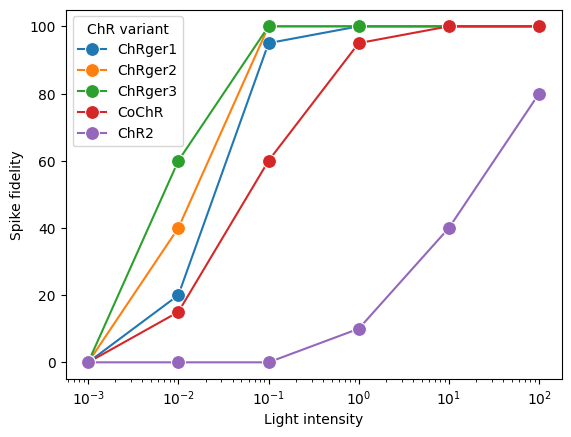

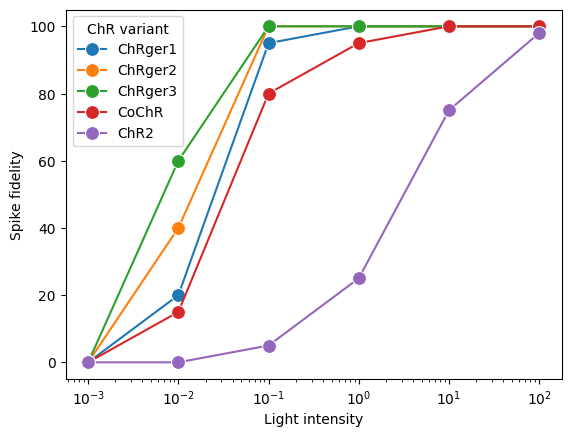

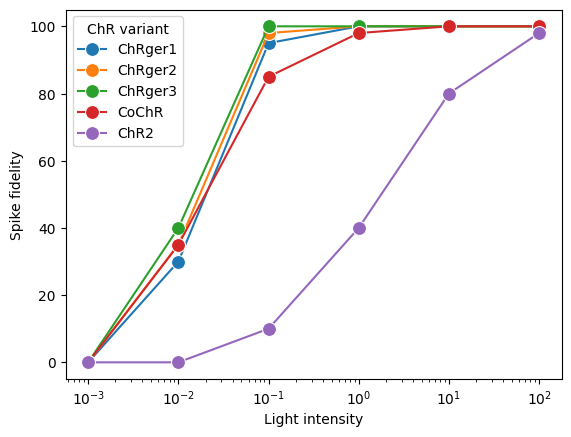

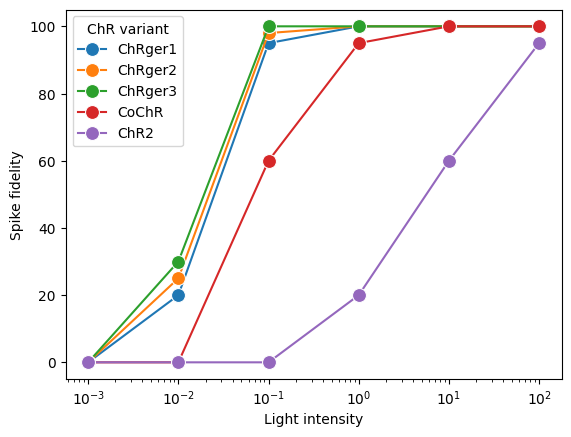

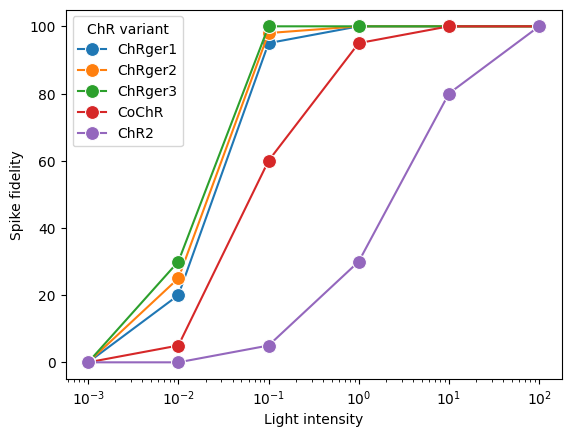

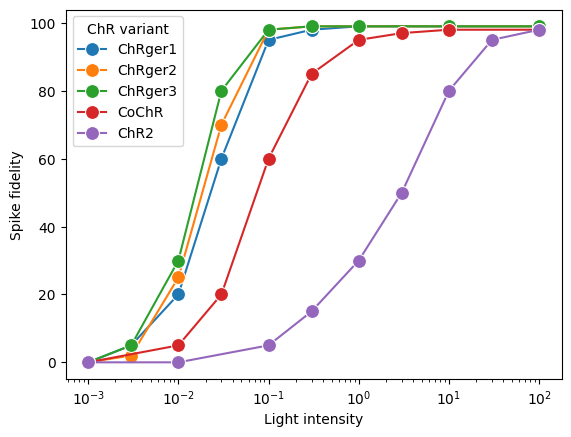

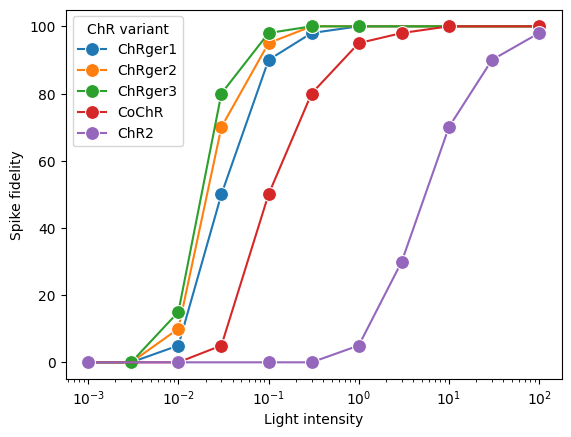

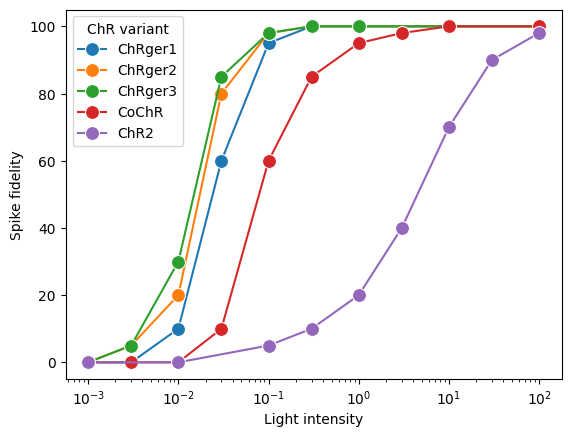

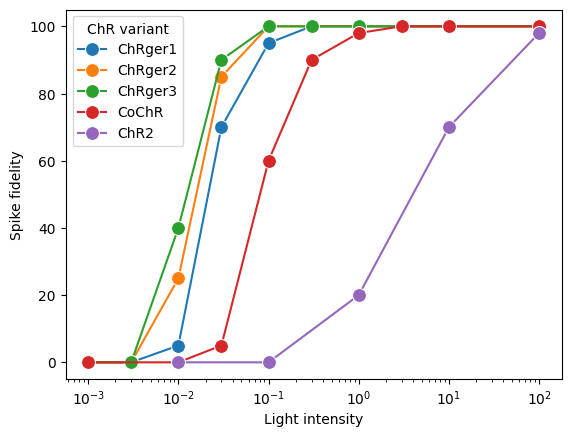

In [366]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots()
sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
    ax=axes
)
axes.semilogx()

# get plot as PIL Image
fig.savefig('plot_0.png')

generated_img_loop = Image.open('plot_0.png')
panel_df_loop = panel_df

for iter in range(10):




    claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620")


    prompt = f"""
    We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
    You will be given the extracted data as a table.
    You will also be given the source figure and a recreation of the plot using our extracted data.
    List the three most important differences between the re-plotted data and the data in the source figure.
    Be specific and refer to specific quantities and values.

    DataFrame:
    {panel_df_loop.to_markdown()}
    """


    response__loop = claude_mm.message(prompt, images = [source_figure, generated_img_loop])

    feedback_loop = response__loop.content[0].text
    print(feedback_loop)

    output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


    columns = {iv.name: pd.Series() for iv in exp.independent_variables}
    dep_var = exp.dependent_variables[0]
    columns.update({dep_var.name: pd.Series()})
    df = pd.DataFrame(columns)

    prompt_base = """
    YOUR OVERALL JOB:
        You were previously given the following task:

            In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?
            And you were asked to return you data in a DataFrame and were provided with information about the independent variables and their values for this plot.

        Here is you the dataframe output from your previous response:
        {df_table}

        We have reviewed your response and notice these important differences from the source data/figure:
        {feedback}

        Please revise your response by incorporating and inspecting the source figure.

    Return your data using the following column schema: {schema}.
    """.format(
        panel_name = panel.name, 
        # dep_var_stat = dep_var.statistics[0],
        plot_name = plot.name,
        dep_var_name = dep_var.name,
        ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
        schema = ", ".join(df.columns),
        feedback = feedback_loop,
        df_table = panel_df_loop.to_markdown(),
    ).replace("{","<").replace("}",">")

    prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    data_response_loop = query_tool(prompt)
    panel_df_loop = output_parser.parse(data_response_loop.content).to_df(existing_df=df)

    # Create a new figure and axes
    fig, axes = plt.subplots()
    
    # Plot the line plot on the new axes
    sns.lineplot(
        data=panel_df_loop,
        x='Light intensity',
        y='Spike fidelity',
        hue='ChR variant',
        marker='o',
        # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
        markersize=10,
        ax=axes
    )
    axes.set_xscale('log')  # Set x-axis to logarithmic scale

    fig.savefig(f'plot_{iter+1}.png')
    generated_img_loop = Image.open(f'plot_{iter+1}.png')

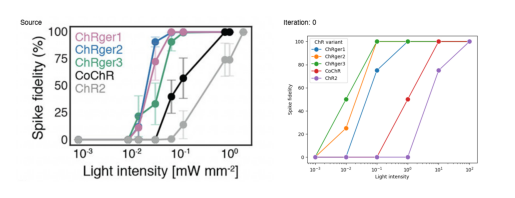

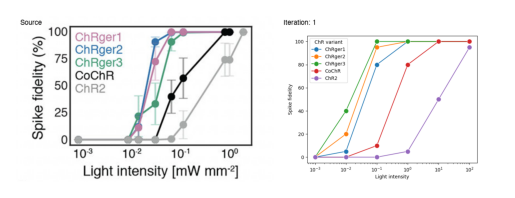

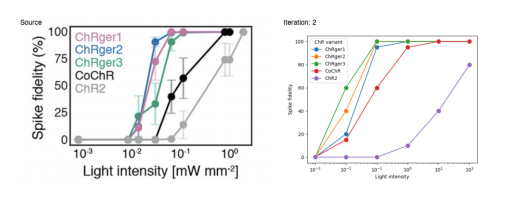

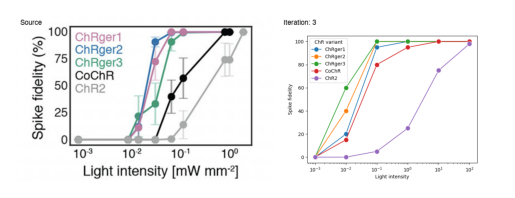

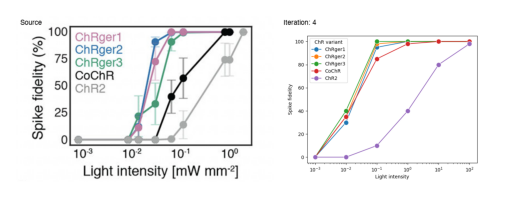

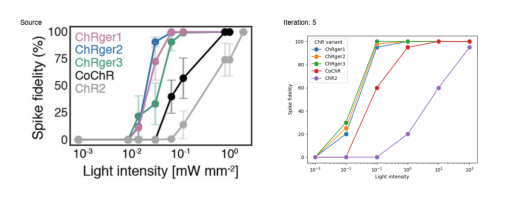

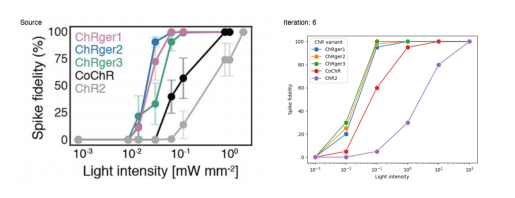

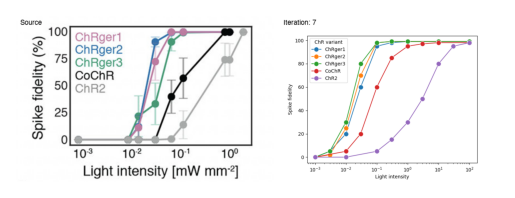

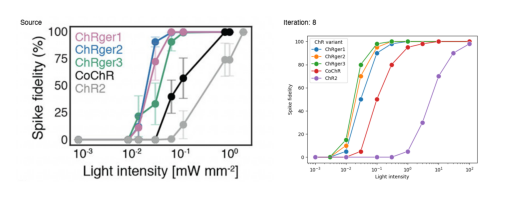

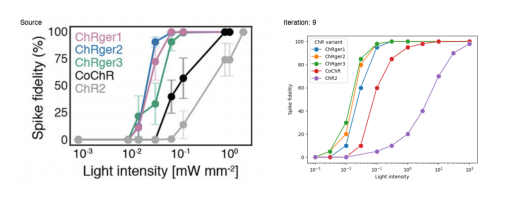

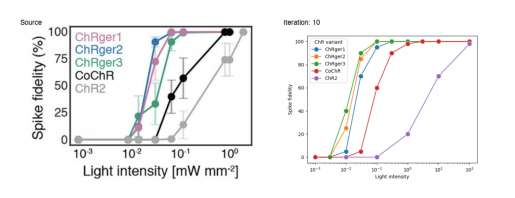

MP4 video saved as 'comparison.mp4'


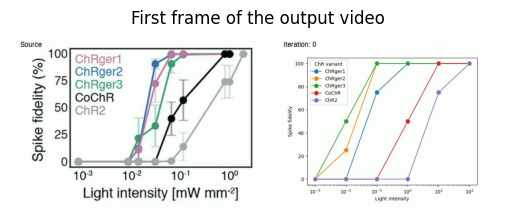

In [381]:
source_panel = '/Users/loyalshababo/dev/plotreader/sandbox/figure3d_pic.png'
generated_fig_panel_path_base = "/Users/loyalshababo/dev/plotreader/sandbox/plot_{iter}.png"

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np

def create_side_by_side_image(source_img, generated_img, iter_number):
    # Resize both images to have the same height
    target_height = 480  # You can adjust this value as needed
    source_img_resized = source_img.resize((int(source_img.width * target_height / source_img.height), target_height))
    generated_img_resized = generated_img.resize((int(generated_img.width * target_height / generated_img.height), target_height))
    
    # Create a new image with the width of both resized images and the target height, plus padding
    padding = 20  # Adjust padding as needed
    total_width = source_img_resized.width + generated_img_resized.width + (3 * padding)  # Extra padding between images
    total_height = target_height + (2 * padding)
    combined_img = Image.new('RGB', (total_width, total_height), color='white')
    
    # Paste the resized source image on the left
    combined_img.paste(source_img_resized, (padding, padding))
    
    # Paste the resized generated image on the right
    combined_img.paste(generated_img_resized, (source_img_resized.width + (2 * padding), padding))
    
    # Add titles to the images
    draw = ImageDraw.Draw(combined_img)
    font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 20)
    
    # Add "Source" title
    draw.text((padding + 10, padding + 10), "Source", fill="black", font=font)
    
    # Add "Iteration: iter_number" title
    draw.text((source_img_resized.width + (2 * padding) + 10, padding + 10), f"Iteration: {iter_number}", fill="black", font=font)
    
    return combined_img

# Load the source panel image
source_img = Image.open(source_panel)

# Create a list to store the frames
frames = []

# Generate frames for each iteration
for iter in range(11):  # 0 to 10
    generated_img_path = generated_fig_panel_path_base.format(iter=iter)
    try:
        generated_img = Image.open(generated_img_path)
        
        # Create the side-by-side image with titles
        combined_img = create_side_by_side_image(source_img, generated_img, iter)
        
        # Convert PIL Image to numpy array
        frame = cv2.cvtColor(np.array(combined_img), cv2.COLOR_RGB2BGR)
        
        # Append the combined image to frames
        frames.append(frame)
    except FileNotFoundError:
        print(f"Warning: Image file not found for iteration {iter}")

# Check if we have any frames
if not frames:
    print("No frames were generated. Check if the image files exist.")
else:
    # Define the output video file
    output_file = 'comparison.mp4'

    # Get the frame size
    height, width, layers = frames[0].shape

    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, 1.0, (width, height))  # 2.0 fps for 5 seconds total with 10 frames

    # Write frames to video
    for frame in frames:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        out.write(frame)

    # Release the VideoWriter
    out.release()

    print(f"MP4 video saved as '{output_file}'")

# Verify the output video
cap = cv2.VideoCapture(output_file)
if cap.isOpened():
    ret, frame = cap.read()
    if ret:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("First frame of the output video")
        plt.show()
    else:
        print("Failed to read the first frame")
    cap.release()
else:
    print("Failed to open the output video file")


/var/folders/0w/7p0llwyd0n39my8_dt311mtr0000gn/T/ipykernel_39940/1437840151.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


[]

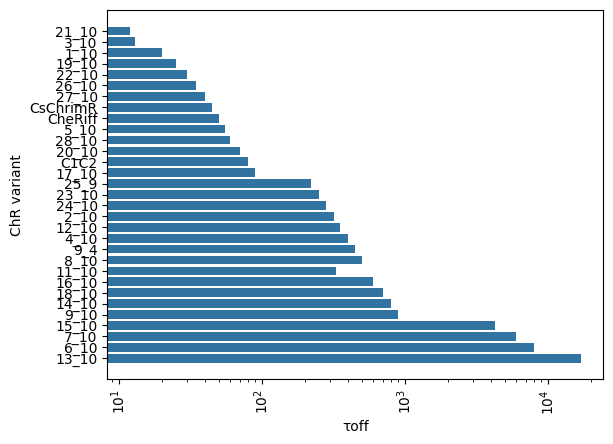

In [27]:
# panel_df_adjusted = panel_df.copy()
# panel_df_adjusted['τoff'] *= 1000

# horizontal bar plot
axes = sns.barplot(
    data=panel_df,
    x='τoff',
    y='ChR variant',
    orient='h',
)
# axes = sns.barplot(
#     data=panel_df,
#     x='ChR variant',
#     y='τoff',
# )
# rotate x-tick labels 90 deg
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.semilogx()



<Axes: xlabel='Wavelength', ylabel='Normalized photocurrent'>

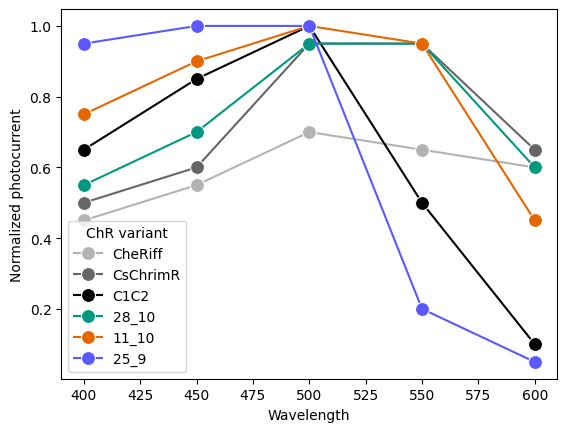

In [127]:


sns.lineplot(
    data=panel_df,
    x='Wavelength',
    y='Normalized photocurrent',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
    palette=[[0.7, 0.7, 0.7], [0.4, 0.4, 0.4], [0, 0, 0], [0, .6 , .5], [0.9, 0.4, 0.0], [0.35, 0.35, 1.0]]
)
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [23]:
from plotreader.utils.structured_types.data import DataFrameRowsOnly
import pandas as pd

In [40]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import MetadataMode

In [42]:
for node in retrieverd_nodes[:-1]:
    try:
        display_source_node(node, source_length=100000)
    except:
        print(node)

**Node ID:** 7cf5ee59-0e97-445f-8884-f4e21f7bba21<br>**Similarity:** 0.40960259534169907<br>**Text:** Figure 2. The model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents. (continued)<br>

**Node ID:** 5cb68f1f-e64c-4502-9da2-c42717a765e2<br>**Similarity:** 0.4057491962557034<br>**Text:** Figure 2. The model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents.<br>

**Node ID:** d04f54e0-29ba-4046-92a6-7d2c6e9268f0<br>**Similarity:** 0.3793601396922902<br>**Text:** Figure 2 shows that the model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents.

Section a shows representative current traces after 0.5 s light exposure for select designer ChR variants with corresponding expression and localization in HEK cells. Vertical scale bar for each ChR current trace represents 1 nA, and horizontal scale bar represents 250 ms. The variant color presented in (a) is constant throughout panels. CheRiff, C1C2 are represented in gray, CsChrimR in black, 11_10 in cyan, 12_10 in magenta, 25_9 in light blue, 10_10 in yellow, 15_10 in blue, 28_10 in orange, 21_10 in purple, and 3_10 in red. The bottom row shows fluorescence images of ChR expression in HEK cells, with a 20 μm scale bar.

Section b displays measured peak and steady-state photocurrent with different wavelengths of light in HEK cells (n=4-8 cells, see Dataset 2). Four wavelengths are shown: 397 nm, 481 nm, 546 nm, and 640 nm. The y-axis shows photocurrent in pA, with different scales for each wavelength. Peak currents are represented by dark gray bars, while steady-state currents are in light gray. Error bars are included.

Section c shows off-kinetics decay rate (τoff) following a 1 ms exposure to 481 nm light at 2.3 mW mm^2 (n=4-8 cells, see Dataset 2). Parent ChRs are highlighted in light gray. The x-axis shows τoff values on a logarithmic scale from 10^1 to 10^4 ms. Inset shows representative current traces with 1 ms light exposure for select ChRs revealing distinct profiles: ChR_21_10 (purple) turns off rapidly, ChR_3_10 (red) and ChR_25_9 (light blue) turn off more slowly, and ChR_15_10 (blue) exhibits little decrease in photocurrent 0.5 s after the light exposure. The time scale for these traces is 100 ms.

Section d shows normalized photocurrent as a function of wavelength for various ChR variants. The wavelengths range from 400 nm to 600 nm. Different colored lines represent different ChR variants, corresponding to the colors in panel a.

Section e displays peak photocurrent (left) and steady-state photocurrent (right) as a function of light intensity for various ChR variants. The x-axis shows light intensity from 10^-1 to 10^1 mW mm^-2 on a logarithmic scale. The y-axis shows photocurrent in pA, up to 2500 pA. Different colored lines represent different ChR variants, corresponding to the colors in panel a. Error bars are included.<br>**Image:**

**Node ID:** 22d9ee84-5d29-4f92-8527-e0ae97939355<br>**Similarity:** 0.36910398090655805<br>**Text:** Selection of designer ChRs using trained models<br>

**Node ID:** 5bbfd688-9a2b-439b-a86b-c786e9c193e7<br>**Similarity:** 0.35990217183769474<br>**Text:** Light delivery and imaging<br>

In [47]:
index_node = node.node

In [49]:
index_node.

'Light delivery and imaging'